# Project 2
### Name: Sheedeh Sharif Bakhtiar
### Student ID: 400422108


---


# **Dataset 1**

### **Question 1**

First, we import pandas and load our train dataframe:



In [207]:
import pandas as pd

df = pd.read_csv("mobile_train.csv")
df.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,0.4950,1.522250,0.509500,4.309500,0.521500,32.046500,0.501750,140.249000,4.520500,...,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000,0.761500,0.503000,0.507000,1.500000
std,439.418206,0.5001,0.816004,0.500035,4.341444,0.499662,18.145715,0.288416,35.399655,2.287837,...,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955,0.426273,0.500116,0.500076,1.118314
min,501.000000,0.0000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,...,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,851.750000,0.0000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,...,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.750000
50%,1226.000000,0.0000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,...,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.500000
75%,1615.250000,1.0000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,...,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.250000
max,1998.000000,1.0000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,...,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


Then, we'll check for any null values in our dataframe:

In [208]:
df.isna().sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

All seems to be well, so we don't need to handle null data. 



Now that we're done with preprocessing, we'll split our dataframe into our features and our target value. Given that we're looking to predict the `price_range` value, all we need to do is to split our dataframe into two halves; one with all columns *but* `price_range`, and one dataframe *only* containing `price_range`.

On top of that, to make things easier, as specified in the question, I'll be reducing the `price_range` number of classes down to 2: high and low. This will make things simpler down the line. If the `price_range` label is 0 or 1, it'll be set to 0 (low) and if the label is 2 or 3, it'll be set to 1 (high)

I'll also be splitting the data into two halves: a train set and a test set. I'll set aside 20% of the data for testing purposes. I'll split the data using sklearn.



In [209]:
from sklearn.model_selection import train_test_split

# Reduce price_range down to two possible classes (rather than 4)
df.loc[df['price_range'] == 1] = 0
df.loc[df['price_range'] > 0] = 1

# Split the data into feature/target
X = df.drop("price_range", axis=1)
Y = df["price_range"]

# Split the now-scaled data into train/test sets
train_x, test_x, train_y, test_y = train_test_split(
    X, Y, test_size=0.2, random_state=0
)


We're looking to do forward selection to find the most effective combination of features with the highest ROC.

In the book, **Introduction to Statistical Learning** by Gareth James, Forward (Stepwise) Selection is described as such:

> Forward stepwise selection
begins with a model containing no predictors, and then adds predictors
to the model, one-at-a-time, until all of the predictors are in the model.
In particular, at each step the variable that gives the greatest additional
improvement to the fit is added to the model.

Then, the best model out of all the models thus so far is chosen as our predictor model.

I will be using vanilla logistic regression as our base model and I'll be using `Scikit-learn`'s implementation, documented here: [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

To do this, I will be making a list of column names, and at every step, I will add a single column to our model, until all columns have been added. 

For the null model, for the `X` value I will feed the model a single column the same shape as the `train_y` column consisting solely of zeros, taking care to set the `fit_intercept` parameter to `True`, effectively creating a null model that only fits an intercept regardless of any features.

The strategy implemented in the following code is as such:

0.   I'll first create a list of column names yet to be added to the model.
1.   First we'll be testing the null model. For this, I'll make sure the `fit_intercept` parameter is set to `True` (despite `True` being the default value), and feed the classifier only zeros for the X parameter in `fit()`.
2.  Then, I'll calculate the AUC using `scikit-learn`'s implementation as documented [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) in a tuple where the first element is the list of columns in our model, the second element corresponds to the AUC score and the third element is the model itself. This tuple will be added to a list, where the best model weights for every step is stored.
3.  I'll then iterate over all columns that haven't been added to our model yet one at a time, always storing the best scoring model.
4.  The best performing model from each step is added to the list, and step 3 is repeated until all features have a weight of 1.
5.  The best performing model from the list is chosen.



In [210]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np
from copy import deepcopy

# Get a list of columns
columns_to_add = list(train_x.columns)

# Results list here. Contains tuple of ([list of columns], AUC score)
best_model_per_step = []

# Train null model
clf = LogisticRegression(fit_intercept=True)
clf.fit(np.zeros(train_y.shape).reshape(-1, 1), train_y)  # Train null model
null_predictions = clf.predict(np.zeros(test_y.shape).reshape(-1, 1))  # It doesn't quite matter what we pass for features in our null model, as it's only predicting based on the intercept that's independent of the features
null_auc_score = roc_auc_score(test_y, null_predictions)
best_model_per_step.append(([], null_auc_score, deepcopy(clf)))


# Forward Stepwise Selection here.
# The loop will keep going as long as there is one feature not included in the model
added_columns = []
while len(columns_to_add) > 0:
  print(f"Round: {len(added_columns)}/{len(list(train_x.columns))-1}")
  current_best_column = ""
  current_best_auc = -1
  current_best_model = -1

  for column in columns_to_add:
    # Choose proposed column
    temp_columns = added_columns.copy()
    temp_columns.append(column)

    # Prepare data
    columns_to_drop = columns_to_add.copy()
    columns_to_drop.remove(column)

    # Drop all columns except the ones we want to use in our 
    temp_train_x = train_x.drop(columns=columns_to_drop, axis=1)
    temp_test_x = test_x.drop(columns=columns_to_drop, axis=1)

    # Create and train proposed model
    clf = LogisticRegression(fit_intercept=True)
    clf.fit(temp_train_x, train_y)

    # Evaluate current model for proposed added column
    temp_pred_y = clf.predict(temp_test_x)
    temp_auc = roc_auc_score(test_y, temp_pred_y, multi_class='ovr')

    # Check and see if current proposed column is the best addition so far
    if temp_auc > current_best_auc:
      current_best_auc = temp_auc
      current_best_column = column
      current_best_model = deepcopy(clf)
  
  # Save column with the largest improvement among all other features
  print(f"Best column for this step: {current_best_column}")
  added_columns.append(current_best_column)
  columns_to_add.remove(current_best_column)
  best_model_per_step.append((added_columns.copy(), current_best_auc, deepcopy(current_best_model)))

# Train final model with all features
clf = LogisticRegression(fit_intercept=True)
clf.fit(train_x, train_y)
pred_y = clf.predict(test_x)
full_auc = roc_auc_score(test_y, pred_y, multi_class='ovr')
best_model_per_step.append((list(train_x.columns), full_auc, clf))

best_model = max(best_model_per_step, key=lambda x:x[1])  # Pick the model with the highest AUC score
print(f"Best model columns: {best_model[0]} with AUC: {best_model[1]}")

Round: 0/19
Best column for this step: m_dep
Round: 1/19
Best column for this step: battery_power
Round: 2/19
Best column for this step: blue
Round: 3/19
Best column for this step: clock_speed
Round: 4/19
Best column for this step: dual_sim
Round: 5/19
Best column for this step: fc
Round: 6/19
Best column for this step: four_g
Round: 7/19
Best column for this step: int_memory
Round: 8/19
Best column for this step: mobile_wt
Round: 9/19
Best column for this step: n_cores
Round: 10/19
Best column for this step: pc
Round: 11/19
Best column for this step: px_height
Round: 12/19
Best column for this step: px_width
Round: 13/19
Best column for this step: ram
Round: 14/19


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Best column for this step: sc_h
Round: 15/19


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Best column for this step: sc_w
Round: 16/19


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Best column for this step: talk_time
Round: 17/19
Best column for this step: three_g
Round: 18/19
Best column for this step: touch_screen
Round: 19/19
Best column for this step: wifi
Best model columns: ['m_dep', 'battery_power'] with AUC: 1.0


As seen above, the best performing model isn't the model with all features, but the model that only uses a subset of these features during training.



### **Question 2**

In this question, I'll be calculating the f1-score, recall and precision on our best performing model with features chosen using forward stepwise selection.

Thankfully, `scikit-learn` has built-in methods that help with calculating and visualizing these metrics. Using `precision_recall_fscore_support` (as documented [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html)), I'll feed the best performing model's predictions and the true test data labels. In return, I'll get an array of length 4, where the first, second and third element correspond to precision, recall and f1-score respectively. (The other returned value is of no interest)

In [211]:
from sklearn.metrics import precision_recall_fscore_support

best_clf = best_model[2]  # Get classifier model from tuple
columns_chosen = best_model[0]

# Change test data so that it fits the current classifier
columns_to_drop = [col for col in list(test_x.columns) if col not in columns_chosen]
fixed_test_x = test_x.drop(columns=columns_to_drop, axis=1)

y_pred = best_clf.predict(fixed_test_x)
precision, recall, f1_score, _ = precision_recall_fscore_support(test_y, y_pred, beta=1)

print(f"Precision:{precision}, recall:{recall}, f1_score:{f1_score}")

Precision:[1. 1.], recall:[1. 1.], f1_score:[1. 1.]


### **Question 3**

The number of columns needed in the best performing model is 2. Using `sklearn.decomposition.PCA` (as documented [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)), we can easily decompose our data.

In [212]:
from sklearn.decomposition import PCA

pca = PCA(n_components=len(columns_chosen))
pca.fit(X)
print(pca.singular_values_)

[36981.54912211 10277.32295916]


### **Question 4**

For retraining the model on our new data, all we'll need to do is repeat what has been done in previous questions, just with new data.

In [213]:
transformed_X = pca.transform(X)

transformed_train_x, transformed_test_x, train_y, test_y = train_test_split(
    transformed_X, Y, test_size=0.2, random_state=0
)

clf = LogisticRegression(fit_intercept=True)
clf.fit(transformed_train_x, train_y)
pred_y = clf.predict(transformed_test_x)

precision, recall, f1_score, _ = precision_recall_fscore_support(test_y, pred_y, beta=1)

print(f"Precision:{precision}, recall:{recall}, f1_score:{f1_score}")

Precision:[1.         0.69836066], recall:[0.50802139 1.        ], f1_score:[0.67375887 0.82239382]


### **Question 5: SVM Kernels**

[As described here](https://www.geeksforgeeks.org/major-kernel-functions-in-support-vector-machine-svm/), simply put, kernel functions are methods used to take data as input and transform it into the required form of processing data.

In **Introduction to Statistical Learning** by Gareth James, kernels in SVMs are described as enlarging the feature space in a certain way to accommodate a non-linear boundary between classes in our n-dimensional space that we wish to fit a hyperplane (Section 9.3.1 and 9.3.2).

However, the "trick" is that kernels don't exactly enlargen our feature space how one might think; it allows us to operate in the *original* feature space without computing the coordinates of the data in a higher dimensional space. ([source](https://medium.com/@zxr.nju/what-is-the-kernel-trick-why-is-it-important-98a98db0961d))

Different SVM algorithms use differing kinds of kernel functions. These functions are of different kinds—for instance, linear, nonlinear, polynomial, radial basis function (RBF), and sigmoid. \ [source](https://dataaspirant.com/svm-kernels/#t-1608054630725)

For instance, some other kernel functions and their use-cases are:


*   **Linear**: They're arguably the simplest kernel function, and thus is the fastest kernel function. This function is preferable when speed is an important factor.
> $k(x_i, x_j) = Σsum(x_i, x_j)$

*   **Polynomial**: Popular in image processing. In the formula below, $d$ is the degree of the polynomial.
> $k(x_i, x_j) = (x_i.x_j+1)^d$

*   **Gaussian**: A general-purpose kernel, used when there is no prior knowledge about the data.
> $k(x_{i},x_{j}) = exp(-\gamma\left\|x_{i} - x_{j}\right\|^{2})$
for $\gamma>0$

*   **Sigmoid**: Used in neural networks, it fits the data to a certain range and forms an 's' shape. This kernel function is similar to a two-layer perceptron model of the neural network, which works as an activation function for neurons.
> $k(x, y) = tanh(\alpha.x^{T}.y + c)$

*   **Linear splines kernel in one-dimension**: It is useful when dealing with large sparse data vectors. It is often used in text categorization. The splines kernel also performs well in regression problems.
> $k(x, y) = 1 + xy + xy.min(x, y) - \frac{x+y}{2}min(x,y)^{2} + \frac{1}{3}min(x,y)^{3}$

*   **ANOVA/Radial basis function (RBF)**: The most preferred kind of kernel function, because it's localized and has a finite response along the complete x-axis. This function tends to perform well in multidimensional regression problems
> $k(x, y) = \Sigma_{k=1}^{n}exp(-σ(x^{k}-y^k)^2)^d$



### **Question 6**

Similar to previous questions, thanks to `scikit-learn`, the process of building and training an SVM model is incredibly simple. I'll be using [sklearn.svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) with the default parameters as they appear to suffice for this particular question.

In [214]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

rbf_clf = SVC()
rbf_clf.fit(train_x, train_y)

pred_y = rbf_clf.predict(test_x)
acc = accuracy_score(test_y, pred_y)

print(f"SVM on mobile data with test accuracy: {acc}")

SVM on mobile data with test accuracy: 0.77


### **Question 7**


In `scikit-learn`, the default kernel in `sklearn.svm.SVC` is `'rbf'`. However, there are a number of kernels we can set for our classifier.

The metric I'll be using to compare classifier with one another will be accuracy, as used in the previous question.

Training SVM with kernel: linear
Accuracy: 1.0
Training SVM with kernel: poly
Accuracy: 0.77
Training SVM with kernel: rbf
Accuracy: 0.77
Training SVM with kernel: sigmoid
Accuracy: 0.77


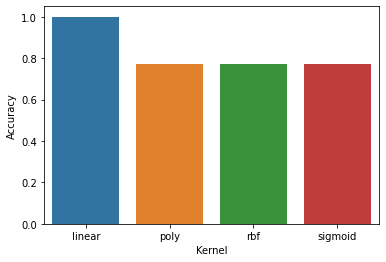

In [215]:
import matplotlib.pyplot as plt
import seaborn as sns

kernels = ["linear", "poly", "rbf", "sigmoid"]
model_dict = {}

for kr in kernels:
  print(f"Training SVM with kernel: {kr}")
  clf = SVC(kernel=kr)
  clf.fit(train_x, train_y)
  pred_y = clf.predict(test_x)
  acc = accuracy_score(test_y, pred_y)
  print(f"Accuracy: {acc}")
  model_dict[kr] = [acc]

# Create barplot
kernel_df = pd.DataFrame.from_dict(model_dict)
ax = sns.barplot(data=kernel_df)
ax.set(xlabel="Kernel", ylabel="Accuracy")
plt.show()

### **Question 8: Soft Margins vs. Hard Margins**

SVM tries to find the hyperplane with the largest margin with respect to the distances of the nearest sample of both classes.

When the data is linearly separable, and we don’t want to have any misclassifications, we use SVM with a hard margin. However, when a linear boundary is not feasible, or we want to allow some misclassifications in the hope of achieving better generality, we can opt for a soft margin for our classifier.

Sources:
*   [baeldung.com](https://www.baeldung.com/cs/svm-hard-margin-vs-soft-margin)
*   [section.io](https://www.section.io/engineering-education/using-a-hard-margin-vs-soft-margin-in-support-vector-machines/)
*   [Sharif University](http://ce.sharif.edu/courses/91-92/2/ce725-2/resources/root/Lectures/Support%20Vector%20Machine%20(SVM).pdf)




### **Question 9**

Same as the previous questions, we'll be using `scikit-learn` to solve the problems outlined in this question. 

#### *A) Binning on `battery_power` with at least 3 bins*

In [216]:
from sklearn.preprocessing import KBinsDiscretizer

N_BINS = 3

X_bin = X.copy()
binner = KBinsDiscretizer(n_bins=N_BINS, encode='ordinal', strategy='kmeans') # With this strategy, bins might not be the same width
binner.fit(X_bin['battery_power'].values.reshape(-1, 1))
X_bin['battery_power'] = binner.transform(X_bin['battery_power'].values.reshape(-1, 1))
X_bin['battery_power'].describe()

count    2000.000000
mean        0.359000
std         0.669584
min         0.000000
25%         0.000000
50%         0.000000
75%         0.250000
max         2.000000
Name: battery_power, dtype: float64

#### *B) One-hot encoding on categorical features*

In [217]:
from sklearn.preprocessing import OneHotEncoder

# Features to transform
categorical_features = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']

X_one_hot = X.copy()
X_temp = X.copy()

# Create temp DataFrame where we'll tranform all categorical features at once.
columns_to_drop = [col for col in list(X.columns) if col not in categorical_features]
X_temp = X_temp.drop(columns=columns_to_drop, axis=1)


enc = OneHotEncoder().fit(X_temp)
new_X_temp = enc.transform(X_temp)


# Add encoded features
for idx, feature in enumerate(categorical_features):
  for i in range(2):
    new_col = new_X_temp[:,idx+i].toarray()
    X_one_hot[f"{feature}-{i}"] = new_col

# Drop original categorical columns
X_one_hot.drop(columns=categorical_features, axis=1)

X_one_hot.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,dual_sim-0,dual_sim-1,four_g-0,four_g-1,three_g-0,three_g-1,touch_screen-0,touch_screen-1,wifi-0,wifi-1
0,0,0,0.0,0,0,0,0,0.0,0,0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,1,1,1.0,1,1,1,1,1.0,1,1,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
2,1,1,1.0,1,1,1,1,1.0,1,1,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
3,1,1,1.0,1,1,1,1,1.0,1,1,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
4,0,0,0.0,0,0,0,0,0.0,0,0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


#### *C) Log transformation*

Log transformation is a data transformation method in which it replaces each variable x with a log(x). The choice of the logarithm base is usually left up to the analyst and it would depend on the purposes of statistical modeling. ([source](https://medium.com/@kyawsawhtoon/log-transformation-purpose-and-interpretation-9444b4b049c9))

Log transformations should be used when our data is skewed and cannot be fixed by filtering outliers, in an attempt to normalize our data and have it fit the bell curve. 

In general, you take logs of a variable when the relationships to that variable are multiplicative rather than additive to remove said skewedness ([source](https://stats.stackexchange.com/questions/82641/how-do-i-know-when-i-should-use-a-log-transformation-on-a-variable-by-multiple-r)), so just by checking which quantitive values are multiplicative should be enough for us to know which values we should log-transform.

For this dataset, we'll use `scipy`'s `skewtest` method (documented [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skewtest.html#scipy.stats.skewtest)) which returns a p-value and z-score relative to a nominal distribution and set a certain threshold that if the calculated p-value is above a certain threshold, we'll perform a log transform.

In [218]:
from scipy.stats import skewtest

P_VALUE_THRES = 0.001

non_categorical_X = X.copy()
non_categorical_X = non_categorical_X.drop(columns=categorical_features, axis=1)

for col in list(non_categorical_X.columns):
  current_col = non_categorical_X[col]
  skew_res = skewtest(current_col)
  print(f"For column {col}: {skew_res}")
  if skew_res.pvalue > P_VALUE_THRES:
    print("Data is skewed!")
    non_categorical_X.loc[col] = non_categorical_X[col].apply(lambda x: log(x)) 


For column battery_power: SkewtestResult(statistic=22.01490511597988, pvalue=2.0730427451762666e-107)
For column clock_speed: SkewtestResult(statistic=12.937742340445343, pvalue=2.7561021191648625e-38)
For column fc: SkewtestResult(statistic=31.365405982789795, pvalue=5.998581519982016e-216)
For column int_memory: SkewtestResult(statistic=24.814140204086456, pvalue=6.3089741243293125e-136)
For column m_dep: SkewtestResult(statistic=-8.491491454687079, pvalue=2.040019311227217e-17)
For column mobile_wt: SkewtestResult(statistic=19.833983170752532, pvalue=1.5154988667224644e-87)
For column n_cores: SkewtestResult(statistic=23.098488672479508, pvalue=4.794777877040834e-118)
For column pc: SkewtestResult(statistic=25.144792613418527, pvalue=1.6112536569945215e-139)
For column px_height: SkewtestResult(statistic=27.53119326805456, pvalue=7.433398358101139e-167)
For column px_width: SkewtestResult(statistic=21.70628795039023, pvalue=1.7893935750941816e-104)
For column ram: SkewtestResult(sta

Thankfully, all of our data has a nominal distribution with incredibly small p-values, so no log-transformation is needed.

#### *D) Adding features*

To add a new feature `sc_area`, all we need to do is to multiply each element of `sc_h` by `sc_w` and add it as a column to our dataframe, which is incredibly simple to do.

In [219]:
sc_area_col = X['sc_h'] * X['sc_w']

with_area_X = X.copy()
with_area_X['sc_area'] = sc_area_col

with_area_X.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,sc_area
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,279.725500,0.621500,0.887550,0.625000,1.521000,0.629500,8.293500,0.622550,35.638000,1.650000,...,134.602000,288.067500,196.828500,3.581000,1.920500,3.153000,0.686500,0.631000,0.624000,20.138000
std,525.228184,0.485134,0.702208,0.484244,2.593631,0.483059,16.017136,0.439685,63.256096,2.086547,...,297.557428,538.980952,385.155563,5.484294,3.038881,5.098293,0.464032,0.482655,0.484501,50.004191
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.750000,0.000000,0.375000,0.000000,0.000000,0.000000,0.750000,0.075000,0.750000,0.750000,...,0.750000,0.750000,0.750000,0.750000,0.000000,0.750000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,126.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.250000,1.000000,20.750000,1.000000,...,1.000000,125.750000,64.750000,2.000000,1.000000,1.250000,1.000000,1.000000,1.000000,1.000000
max,1994.000000,1.000000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,...,1878.000000,1989.000000,1974.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,342.000000


### **Question 10** 


First, we'll fit an SVM onto each of our generated dataframes from the previous question:

Bin accuracy: 0.77
One hot accuracy: 0.77
SC_area accuracy: 0.77


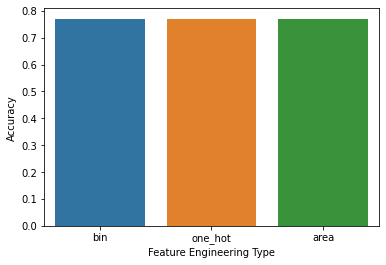

In [220]:
rbf_clf = SVC()
results = {}


# A) Binning

train_x, test_x, train_y, test_y = train_test_split(
    X_bin, Y, test_size=0.2, random_state=0
)
rbf_clf.fit(train_x, train_y)
pred_y_bin = rbf_clf.predict(test_x)
acc_bin = accuracy_score(test_y, pred_y_bin)
results['bin'] = [acc_bin]
print(f"Bin accuracy: {acc_bin}")

# B) One-hot encoding
train_x, test_x, train_y, test_y = train_test_split(
    X_one_hot, Y, test_size=0.2, random_state=0
)
rbf_clf.fit(train_x, train_y)
pred_y_oh = rbf_clf.predict(test_x)
acc_oh = accuracy_score(test_y, pred_y_oh)
results['one_hot'] = [acc_oh]
print(f"One hot accuracy: {acc_oh}")



# C) Log-transformation
#### No changes were done

# D) Feature adding
train_x, test_x, train_y, test_y = train_test_split(
    with_area_X, Y, test_size=0.2, random_state=0
)
rbf_clf.fit(train_x, train_y)
pred_y_area = rbf_clf.predict(test_x)
acc_area = accuracy_score(test_y, pred_y_area)
results['area'] = [acc_area]
print(f"SC_area accuracy: {acc_area}")


# Create barplot
res_df = pd.DataFrame.from_dict(results)
ax = sns.barplot(data=res_df)
ax.set(xlabel="Feature Engineering Type", ylabel="Accuracy")
plt.show()

Then, we'll combine all the altered dataframes to create a dataframe where the features have been engineered as per the previous question and fit a SVM onto it:

In [221]:
alt_X = X.copy()

# First, removing categorical columns and adding the encoded columns
# Columns not in X_one_hot but in alt_X are the original, non-encoded columns and should be removed,
# and columns in X_one_hot but not in alt_X are the encoded columns and should be added
org_columns = list(alt_X.columns)
new_columns = list(X_one_hot.columns)

columns_to_drop = [col for col in org_columns if col not in new_columns]
alt_X = alt_X.drop(columns=columns_to_drop, axis=1)

columns_to_add = [col for col in new_columns if col not in org_columns]
for col in columns_to_add:
  alt_X[col] = X_one_hot[col]

# Then, adding the binned data
alt_X['battery_power'] = X_bin['battery_power']

# Lastly, adding the screen area column
alt_X['sc_area'] = with_area_X['sc_area']

# Train/Test split the data and finally, train our SVM
clf = SVC()
train_x, test_x, train_y, test_y = train_test_split(
    alt_X, Y, test_size=0.2, random_state=0
)
clf.fit(train_x, train_y)
pred_y = clf.predict(test_x)
final_acc = accuracy_score(test_y, pred_y)

print(f"SVM accuracy with all engineered features: {final_acc}")

SVM accuracy with all engineered features: 0.77


### **Question 11: Decision Tree Algorthms** 

There are a few different algorithms for deriving decision trees. Here are some of them:

1. **ID3 (Iterative Dichotomiser)**: This algorithm creats a multiway tree. It uses Information Gain as attribute selection measure and has a greedy approach. After trees have been grown to their maximum size, a pruning step is usually applied to improve the ability of the tree to generalise to unseen data.

2. **C4.5**:  The successor to ID3, this algorithm removes the restriction that features must be categorical by dynamically defining a discrete attribute based on numerical variables that partitions the continuous attribute value into a discrete set of intervals. This algorithm converts trained trees into sets of if-then rules. Pruning is done by removing a rule’s precondition if the accuracy of the rule improves without it. Uses Gain Ratio as attribute selection measure.

3. **CART (Classification and Regression Trees)**: Very similar to C4.5, this is a greedy algorithm that searches for an optimum split at the top level, and then repeats this process for each of the subsequent levels. Moreover, it does verify whether the split will lead to the lowest impurity or not as well as the solution provided by the greedy algorithm is not guaranteed to be optimal, it often produces a solution that’s reasonably good since finding the optimal Tree is an NP-Complete problem that requires exponential time complexity. This algorithm uses the Gini Index as attribute selection measure.


Sources:
*   [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2021/05/25-questions-to-test-your-skills-on-decision-trees/)
*   [medium](https://medium.datadriveninvestor.com/tree-algorithms-id3-c4-5-c5-0-and-cart-413387342164)


### **Question 12** 

Similar to previous questions, I'll be using `sklearn` to build a decision tree. Specifically, I'll be using the `DecisionTreeClassifer` as documented [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier).

In [222]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf = clf.fit(train_x, train_y)

pred_y = clf.predict(test_x)
tree_acc = accuracy_score(test_y, pred_y)

print(f"Decision tree accuracy: {tree_acc}")

Decision tree accuracy: 1.0


### **Question 13** 

There are several parameters we can evaluate and compare when it comes to decision trees. The first of which would be the splitting criterion.

#### *Splitting Criterion*
`scikit-learn`'s `DecisionTreeClassifier` offers three different types of criterion for measuring the quality of a split. They are gini, entropy, and log loss, with gini being the default value.

**Gini impurity** ranges values from 0 to 0.5 (with 0 being the best and 0.5 being the "worst"), and the formula is as shown below:

$Gini(t) = 1 - \Sigma_{i=1}^jP(i|t)^2$

Where $j$ represents the number of classes in the label and $P$ represents the ratio of class at the $i$th node. A gini index of 0 suggests that a node is a leaf and it is the purest node.

The **entropy** of any random variable or random process is the average level of uncertainty involved in the possible outcome of the variable or process. Mathematically, the formula for entropy is shown below:

$Entropy(X) = -\Sigma_{i=1}^nlogP(x_i)$

Where $X$ is the random variable or process, $X_i$ is the possible outcome or class, and $P(X_i)$ is the probability for that specific class.

**Log-loss** on the other hand, is indicative of how close the prediction probability is to the corresponding actual/true value (0 or 1 in case of binary classification). The more the predicted probability diverges from the actual value, the higher is the log-loss value. Log-loss is calculated using the formula below:

$LogLoss(X) = -\left [ y_ilnp_i + (1-y_i)ln(1-p_i)\right ]$

Where $i$ is the given observation/record, $y$ is the actual/true value, $p$ is the prediction probability, and $ln$ refers to the natural logarithm of a number.

The performance of these criteria is tested and graphed below:


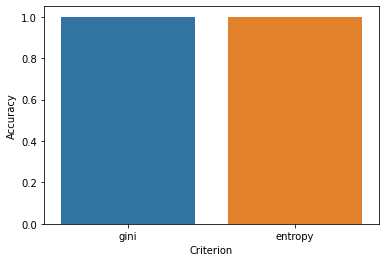

In [223]:
criterion_res = {}
criterion = ["gini", "entropy"]

for criteria in criterion:
  clf = DecisionTreeClassifier(criterion=criteria)
  clf = clf.fit(train_x, train_y)

  pred_y = clf.predict(test_x)
  tree_acc = accuracy_score(test_y, pred_y)
  criterion_res[criteria] = [tree_acc]


# Create barplot
criteria_df = pd.DataFrame.from_dict(criterion_res)
ax = sns.barplot(data=criteria_df)
ax.set(xlabel="Criterion", ylabel="Accuracy")
plt.show()


#### *Max Depth*

As per `scikit-learn`'s documentation, `DecisionTreeClassifier` has a `max_depth` parameter that specifies the maximum depth of the tree. If `None`, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

We'll test our model's accuracy for max depths of 1, 5, 10, 20, 50 and `None` (infinity).

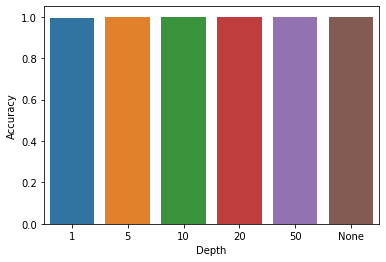

In [224]:
sample_depths = [1, 5, 10, 20, 50, None]
depth_res = {}

for depth in sample_depths:
  clf = DecisionTreeClassifier(max_depth=depth)
  clf = clf.fit(train_x, train_y)

  pred_y = clf.predict(test_x)
  depth_acc = accuracy_score(test_y, pred_y)
  depth_res[str(depth)] = [depth_acc]


# Create barplot
depth_df = pd.DataFrame.from_dict(depth_res)
ax = sns.barplot(data=depth_df)
ax.set(xlabel="Depth", ylabel="Accuracy")
plt.show()


#### *Minimum Samples to Split*

As per `scikit-learn`'s documentation, the `min_samples_split` paramter refers to the minimum number of samples required to split an internal node. It's default value is 2. I'll be testing for paramter values 2, 3, 5 and 10.


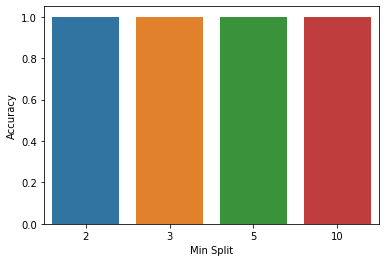

In [225]:
sample_split = [2, 3, 5, 10]
split_res = {}

for split in sample_split:
  clf = DecisionTreeClassifier(min_samples_split=split)
  clf = clf.fit(train_x, train_y)

  pred_y = clf.predict(test_x)
  split_acc = accuracy_score(test_y, pred_y)
  split_res[str(split)] = [split_acc]


# Create barplot
split_df = pd.DataFrame.from_dict(split_res)
ax = sns.barplot(data=split_df)
ax.set(xlabel="Min Split", ylabel="Accuracy")
plt.show()

### **Question 14: Pruning and what is it used for** 

One of the questions that arises in a decision tree algorithm is the optimal size of the final tree. A tree that is too large risks overfitting the training data and poorly generalizing to new samples. A small tree might not capture important structural information about the sample space. However, it is hard to tell when a tree algorithm should stop because it is impossible to tell if the addition of a single extra node will dramatically decrease error. This problem is known as the horizon effect. A common strategy is to grow the tree until each node contains a small number of instances then use pruning to remove nodes that do not provide additional information

Pruning a decision tree helps to prevent overfitting the training data so that our model generalizes well to unseen data. Pruning a decision tree means to remove a subtree that is redundant and not a useful split and replace it with a leaf node. Decision tree pruning can be divided into two types: pre-pruning and post-pruning.

Pre-prunning is when the subtree construction is halted at a particular node after some kind of evaluation, such as Gini Impurity or Information gain. Post-pruning is pruning after the tree is built, working from the bottom-up and based on various measures such as Gini Impurity or Information Gain, deciding whether or not a certain node should be replaced with a leaf node.

Pruning and early stopping help quite a bit with the trade-offs involved when using algorithms such as CART.

Sources:
*   [educative.io](https://www.educative.io/edpresso/what-is-decision-tree-pruning-and-how-is-it-done)
*   [wikipedia](https://en.wikipedia.org/wiki/Decision_tree_pruning)
*   [displayr.com](https://www.displayr.com/machine-learning-pruning-decision-trees/)


### **Question 15: Bootstrapping and it's difference with cross validation** 
In statistics, Bootstrap Sampling is a method that involves drawing of sample data repeatedly with replacement from a data source to estimate a population parameter. By “with replacement”, we mean that the same data point may be included in our resampled dataset multiple times.

In general, the steps involved in bootstrapping are as such:

1.  Choose a number of bootstrap samples to perform
2.  Choose a sample size
3.  For each bootstrap sample 
  1.  Draw a sample with replacement with the chosen size
  2.  Fit a model on the data sample
  3.  Estimate the skill of the model on the out-of-bag sample.
4.  Calculate the mean of the sample of model skill estimates.

Bootstrapping allows us to generate a distribution of estimates, rather than a single point estimate and it allows us to estimate uncertainty, allowing computation of confidence intervals.

However, it is commonly confused with cross-validation. While cross-validation is also a resampling method, there are a couple key differences:
*  Bootstrap resamples with replacement. Due to the drawing with replacement, a bootstrapped data set may contain multiple instances of the same original cases, and may completely omit other original cases. However, cross-validation resamples without replacement and produces new datasets smaller than the original.
*  As the name cross validation suggests, its primary purpose is measuring (generalization) performance of a model. On contrast, bootstrapping is primarily used to establish empirical distribution functions for a widespread range of statistics (widespread as in ranging from, say, the variation of the mean to the variation of models in bagged ensemble models).

Sources:
*   [analyticsvidhya.com](https://www.analyticsvidhya.com/blog/2020/02/what-is-bootstrap-sampling-in-statistics-and-machine-learning/)
*   [carpentries-incubator on GitHub](https://carpentries-incubator.github.io/machine-learning-novice-python/08-bootstrapping/index.html)
*   [machinelearningmastery.com](https://machinelearningmastery.com/a-gentle-introduction-to-the-bootstrap-method/)
*  [stackexchange](https://datascience.stackexchange.com/questions/32264/what-is-the-difference-between-bootstrapping-and-cross-validation)

### **Question 16: 5x2 cross validation and it's uses** 

Nested cross-validation (CV) is often used to train a model in which hyperparameters also need to be optimized. Nested CV estimates the generalization error of the underlying model and its (hyper)parameter search.

In simpler terms, it's validation for our validation set, or rather, inner-validation.

This procedure can be used both when optimizing the hyperparameters of a model on a dataset, and when comparing and selecting a model for the dataset. When the same cross-validation procedure and dataset are used to both tune and select a model, it is likely to lead to an optimistically biased evaluation of the model performance.

5x2 cross-validation is a special case of nested cross validation, and refers to a 5 repetition of a 2-fold and is introduced as a way of obtaining not only a good estimate of the generalisation error but also a good estimate of the variance of that error (in order to perform statistical tests).

Nested CV is not critically important if your data set is large and without outliers. If your data do have outliers, than cross validation performance may be drastically different depending on what fold/folds these outliers are in. Therefore you repeat CV several times.

Sources:
*  [scikit-learn's documentation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html)
*  [machinelearningmastery.com](https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/)
*  [analyticsvidhya.com](https://www.analyticsvidhya.com/blog/2021/03/a-step-by-step-guide-to-nested-cross-validation/)
*  [stackexchange](https://stats.stackexchange.com/questions/151710/nested-cross-validation-how-is-it-different-from-model-selection-via-kfold-cv)

### **Question 17** 




---

# **Dataset 2**

### **Question 1: Bayes Theorem and different classifiers**

Bayes' theorem describes the probability of an event, based on prior knowledge of conditions that might be related to that event. Using this theorem, we can use Bayesian inference, which is a statistical inference approach. 

Bayes' theorem is stated below:

$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$

Where $A$ and $B$ are events and $P(B)\neq0$. By calculating the probabilities on the right side of the equation, we can essentially "work backwards", and find the probability on the left hand side. 

For instance, in machine learning, if we were to calculate how likely it was a certain set of features was to be seen given a certain class (e.g. $P(x_1, x_2, x_3 | y)$), over a large enough dataset, we could approximate that given another set of features, such as $x_4, x_5, x_6$, we'd be able to correctly guess $P(y| x_4, x_5, x_6)$.

There are different classifiers that work off of this idea that are useful for different scenarios, described below:

*  **Gaussian Naive Bayes**: A naive Bayes classifier is called in this way because it’s based on a naive condition, which implies the conditional independence of causes. This can seem very difficult to accept in many contexts where the probability of a particular feature is strictly correlated to another one. Gaussian Naive Bayes is useful when working with continuous values which probabilities can be modeled using a Gaussian distribution.
Because of the assumption of the normal distribution, Gaussian Naive Bayes is used in cases when all our features are continuous. For example in Iris dataset features are sepal width, petal width, sepal length, petal length. So its features can have different values in data set as width and length can vary. We can’t represent features in terms of their occurrences. This means data is continuous. Hence we use Gaussian Naive Bayes here.


*  **Bernoulli Naive Bayes**: It assumes that all our features are binary such that they take only two values. Their probabilities are as shown below:

>  $P(X) = \left\{\begin{matrix}
 p&  if&  X=1\\
 q&  if&  X=0\\
\end{matrix}\right.
where$
$q = 1-p$ and $0 < p < 1$

*  **Multinomial Naive Bayes**: A multinomial distribution is useful to model feature vectors where each value represents, for example, the number of occurrences of a term or its relative frequency. If the feature vectors have n elements and each of them can assume $k$ different values with probability $p_k$, then:

>  $P(X_1 = x_1 \cap X_2 = x_2 \cap ... \cap X_k = x_k) = \frac{n!}{\prod_{i}x_i!}\prod_{i}p_i^{x_i}$



Sources:
*   [Wikipedia](https://en.wikipedia.org/wiki/Bayes%27_theorem)
*   [Quora](https://www.quora.com/What-is-the-difference-between-the-the-Gaussian-Bernoulli-Multinomial-and-the-regular-Naive-Bayes-algorithms)
*   [packtpub](https://hub.packtpub.com/implementing-3-naive-bayes-classifiers-in-scikit-learn/)




### **Question 2**

In this, I'll create a Naive Bayes Estimator from scratch using three features: "chol", "trestbps", and "thalach".

One issue we have here is that these features are continuous, and not discrete. Here we are faces with many issues, one being the *zero frequency problem* that skews the performance of the entire classifier. It occurs when an instance in a test dataset has a category that was not present during training, and thus will be assigned the probability of 0.

All three of our features; `trestbps` (which indicate resting bps), `thalach` (which indicates the maximum heartrate achieved) and `chol` (which represents cholesterol) are continuous, and during testing we may see values we've never seen before.

We can solve this problem by binning, and replacing values with thir bin number. Similar to before, we'll use `scikit-learn` to simplify the process of binning. We'll give each feature 10 bins.

For ease of calculation, we'll assume all 3 of these features are independent.

In [226]:
import numpy as np

# Load second dataset
df = pd.read_csv('heart.csv')

features_to_use = ['chol', 'trestbps', 'thalach']
columns_to_drop = [col for col in list(df.columns) if col not in features_to_use]

X_all = df.copy()
X_all = X_all.drop(columns=columns_to_drop, axis=1)

Y_all = df['target']

# Bin continuous features.
N_bins = 10
est = KBinsDiscretizer(n_bins=N_bins, encode='ordinal', strategy='quantile')
for feature in features_to_use:
  current_col = X_all[feature].values.reshape(-1, 1)
  est.fit(current_col)
  X_all[feature] = est.transform(current_col)
  df[feature] = X_all[feature]

# Train/test split - for the next question
X, test_x, Y, test_y = train_test_split(
    X_all, Y_all, test_size=0.2, random_state=0
)

##### Naive Bayes Model
# First, calculate probabilities for all classes. (priors)
classes = list(Y_all.unique())
priors = {}

for class_ in classes:
  n_class = df[df['target'] == class_].shape[0]
  priors[class_] = n_class / Y.shape[0]

# Second, calculate a specific feature value likelihood for each target class given a Gaussian distribution 
likelihoods = {}
df_per_class = [df[df['target'] == c] for c in classes]

for i, c in enumerate(classes):
  current_dict = {}
  current_df = df_per_class[i]
  for feature in features_to_use:
    current_dict[feature] = {}
    mean, std = current_df[feature].mean(), current_df[feature].std()
    unique_vals_for_feature = list(X_all[feature].unique())
    for u_feature in unique_vals_for_feature:
      x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) *  np.exp(-((u_feature-mean)**2 / (2 * std**2 )))
      current_dict[feature][u_feature] = x_given_y
  likelihoods[c] = current_dict.copy()

# Final prediction method
def calculate_probability(X, likelihoods_dict = likelihoods, class_priors = priors):
  results = []
  for x in X.values:
    probabilities = [1, 1]
    for i, c in enumerate(classes):
      for feat_idx, feat_val in enumerate(x):
        try:
          probabilities[i] *= likelihoods_dict[c][features_to_use[feat_idx]][feat_val]
        except KeyError:
          probabilities[i] = 0
          break
      probabilities[i] *= class_priors[c]
    results.append(probabilities.copy())
  final_pred = [np.argmax(res) for res in results]
  return final_pred

predictions = calculate_probability(test_x)
print(f"Accuracy: {accuracy_score(predictions, test_y)}")

Accuracy: 0.22950819672131148


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


### **Question 3**

In the previous question, I had split the data into a train (`X`/`Y`) and test (`test_x`/`test_y`) set such that 80% of the data was allocated to training and 20% of the data was allocated to testing.

For calculating precision, recall and the f1 score, I'll use the same method as I had in the previous section.

In [227]:
precision, recall, f1_score, _ = precision_recall_fscore_support(test_y, predictions, beta=1)

print(f"Precision:{precision}, recall:{recall}, f1_score:{f1_score}")

Precision:[0.23684211 0.2173913 ], recall:[0.33333333 0.14705882], f1_score:[0.27692308 0.1754386 ]


### **Question 4**

As mentioned in the question, `scikit-learn` provides us with an implementation of Gaussian Naive Bayes known as `GaussianNB` (as documented [here](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)). For ease and higher accuracy, I'll be using the binned data.

In [228]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X, Y)
y_pred = clf.predict(test_x)
print(f"Accuracy: {accuracy_score(y_pred, test_y)}")

precision, recall, f1_score, _ = precision_recall_fscore_support(test_y, y_pred, beta=1)
print(f"Precision:{precision}, recall:{recall}, f1_score:{f1_score}")

Accuracy: 0.8032786885245902
Precision:[0.77777778 0.82352941], recall:[0.77777778 0.82352941], f1_score:[0.77777778 0.82352941]


### **Question 5**

It's quite clear that `scikit-learn`'s model has performed *much* better than my implementation with `numpy`. This is mostly due to the fact that `GaussianNB` has a few built-in features that allow it to learn more from the data without being so sensitive to fluctutations in the data, such as normal distribution and whatnot. One example of these features can be seen in the `var_smoothing` variable which specifies the portion of the largest variance of all features that is added to variances for calculation stability.